In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from sklearn.utils import class_weight





In [17]:
from google.colab import files
uploaded = files.upload()


Saving Dataset.zip to Dataset.zip


In [18]:
import zipfile

with zipfile.ZipFile("Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()


os.listdir("Dataset")


['No_Fibrosis', 'Fibrosis']

In [32]:
import os
import shutil
import random


original_dataset_dir = 'Dataset'
base_dir = 'Processed_Dataset'
os.makedirs(base_dir, exist_ok=True)


splits = ['train', 'val', 'test']
classes = ['Fibrosis', 'No_Fibrosis']
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)


train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for cls in classes:
    files = os.listdir(os.path.join(original_dataset_dir, cls))
    random.shuffle(files)
    total = len(files)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for f in train_files:
        src = os.path.join(original_dataset_dir, cls, f)
        dst = os.path.join(base_dir, 'train', cls, f)
        shutil.copy2(src, dst)

    for f in val_files:
        src = os.path.join(original_dataset_dir, cls, f)
        dst = os.path.join(base_dir, 'val', cls, f)
        shutil.copy2(src, dst)

    for f in test_files:
        src = os.path.join(original_dataset_dir, cls, f)
        dst = os.path.join(base_dir, 'test', cls, f)
        shutil.copy2(src, dst)



In [34]:
batch_size = 8
img_size = (128, 128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Processed_Dataset/train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Processed_Dataset/val",
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Processed_Dataset/test",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Found 4426 files belonging to 2 classes.
Found 878 files belonging to 2 classes.
Found 877 files belonging to 2 classes.


In [37]:
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

number of photos 4623


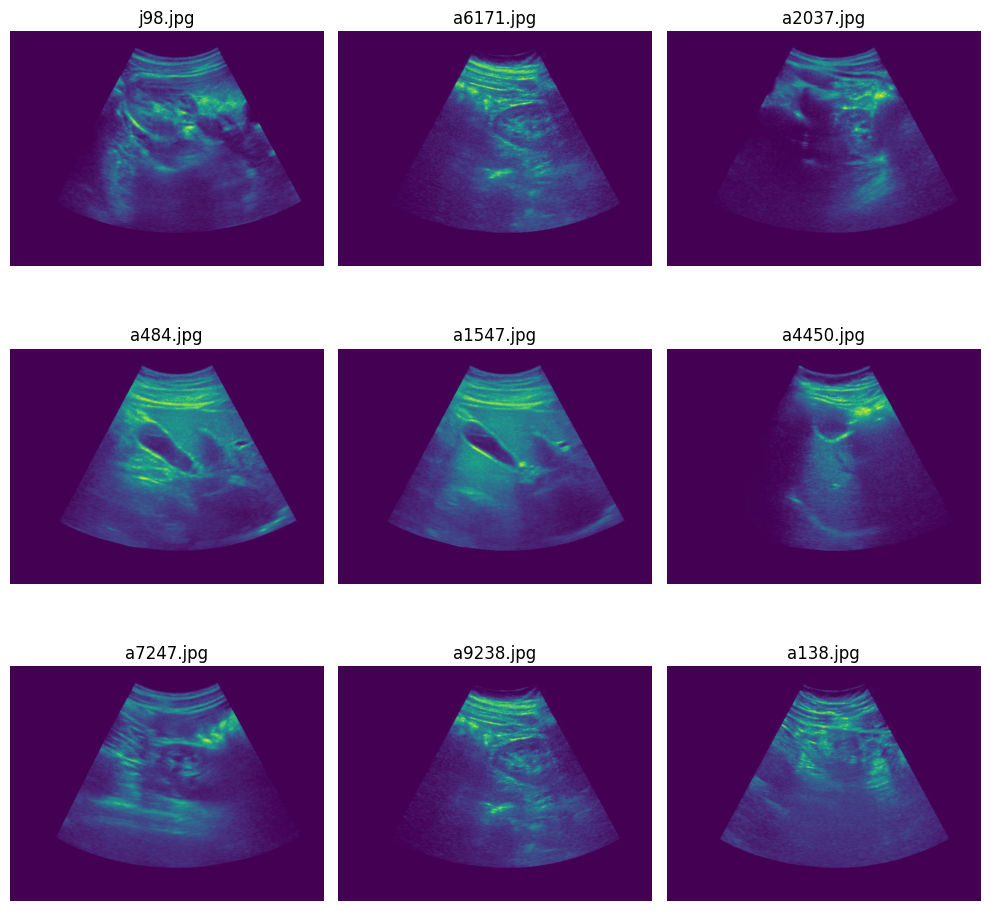

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt

folder_path = "Dataset"


image_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

print("number of photos", len(image_files))

plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_files))):
    img_path = image_files[i]
    img = Image.open(img_path)

    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path))
    ax.axis("off")

plt.tight_layout()
plt.show()


In [38]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [39]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 169s 298ms/step - accuracy: 0.8953 - loss: 0.2696 - val_accuracy: 0.9077 - val_loss: 0.2377
Epoch 2/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 160s 288ms/step - accuracy: 0.9267 - loss: 0.2007 - val_accuracy: 0.9556 - val_loss: 0.2132
Epoch 3/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 153s 276ms/step - accuracy: 0.9442 - loss: 0.1615 - val_accuracy: 0.9692 - val_loss: 0.1710
Epoch 4/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 153s 275ms/step - accuracy: 0.9583 - loss: 0.1230 - val_accuracy: 0.9738 - val_loss: 0.0969
Epoch 5/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 154s 278ms/step - accuracy: 0.9536 - loss: 0.1187 - val_accuracy: 0.9818 - val_loss: 0.1060
Epoch 6/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 205s 283ms/step - accuracy: 0.9674 - loss: 0.1026 - val_accuracy: 0.9852 - val_loss: 0.0629
Epoch 7/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 201s 281ms/step - accuracy: 0.9764 - loss: 0.0725 - val_accuracy: 0.9692 - val_loss: 0.0783
Epoch 8/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 201s 279ms/step - accuracy: 0.9751 -

In [52]:
from sklearn.metrics import classification_report


y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()


print(classification_report(y_true, y_pred, target_names=["No_Fibrosis", "Fibrosis"]))


110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step
              precision    recall  f1-score   support

 No_Fibrosis       0.98      0.99      0.98       480
    Fibrosis       0.98      0.97      0.98       397

    accuracy                           0.98       877
   macro avg       0.98      0.98      0.98       877
weighted avg       0.98      0.98      0.98       877



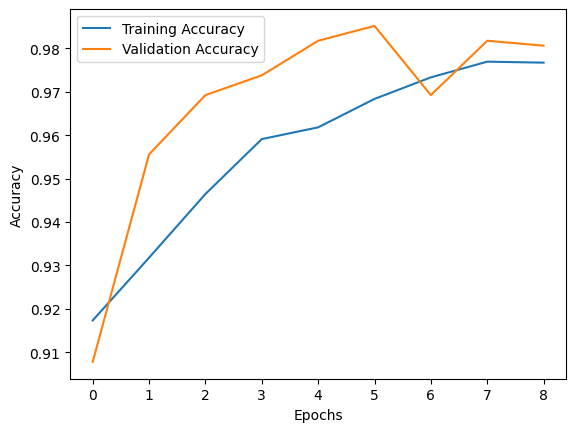

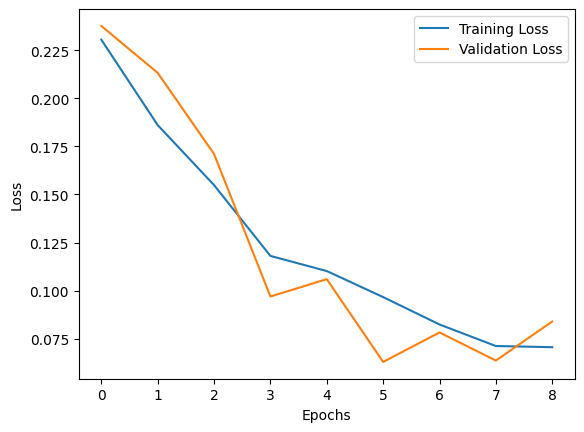

In [53]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
from google.colab import files
uploaded = files.upload()


Saving a1.jpg to a1.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


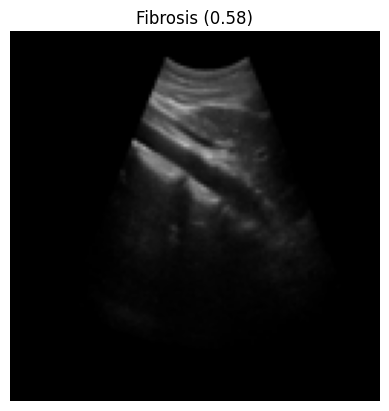

In [51]:
from PIL import Image


image_path = "a1.jpg"


img = Image.open(image_path).resize((128, 128)).convert('RGB')
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = img_array / 255.0

prediction = model.predict(img_array)


plt.imshow(img)
plt.axis("off")
label = "Fibrosis" if prediction[0][0] >= 0.5 else "No_Fibrosis"
confidence = prediction[0][0] if prediction[0][0] >= 0.5 else 1 - prediction[0][0]
plt.title(f"{label} ({confidence:.2f})")
plt.show()


In [54]:
model.save("liver_classification_model.h5")


from google.colab import files
files.download('liver_classification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>